# STEP1: QC, normalize, and cluster

In this notebook, we will QC, normalize and cluster ONE example sample's snRNA-seq data. We will develop a few functions, which we can then plug into a pipeline to process MORE samples automatically.

## Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scrublet as scr
import seaborn as sns
import seaborn.objects as so
from pipeline.utils import load_h5_data
from pathlib import Path

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 0
sc.settings.figdir = '/Users/haochen/Desktop/prePOLAR/snRNAseq/hz-analysis/outputs/Step1-individual-QC_norm_cluster/PP01'
sc.settings.figdir.mkdir(parents=True, exist_ok=True)
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

from matplotlib.pyplot import rc_context
from matplotlib.backends.backend_pdf import PdfPages

## load data

In [2]:
h5 = '/Users/haochen/Desktop/prePOLAR/snRNAseq/hz-analysis/outputs/00-UMI_curves&raw_QC/CellBender_outputs/PP01.cellbender_filtered_filtered.h5'


# --- here we define a function which wraps two commands: 
# read_10x_h5 and var_names_make_unique
def load_h5_data(filename):
    adata = sc.read_10x_h5(filename)
    ncells, ngenes = adata.shape
    adata.var_names_make_unique()
    return adata

adata = load_h5_data(h5)

/Users/haochen/Desktop/prePOLAR/snRNAseq/tools/scanpy/scanpy/readwrite.py:281: FutureWarning: X.dtype being converted to np.float32 from uint32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(
/Users/haochen/anaconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## [Unnecessary, don't use] set up R environment and install necessary packages

This block of code is for if you want to use any R packages in this analysis.
For now we are not using any, so we could skip to the next one.

In [1]:
import rpy2
import anndata2ri
import rpy2.robjects as ro
import rpy2.rinterface_lib.callbacks as rcb
from rpy2.robjects.packages import importr
base = importr('base')

import logging
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

# how to call functions in R
# https://stackoverflow.com/questions/49776568/calling-functions-from-within-r-packages-in-python-using-importr

##  Basic QC plots (for development only; already integrated into util function)

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, percent_top=(20, 50,), qc_vars=['mt'],inplace=True)

# adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

In [7]:
adata

AnnData object with n_obs × n_vars = 2546 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

/Users/haochen/Desktop/prePOLAR/snRNAseq/tools/scanpy/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


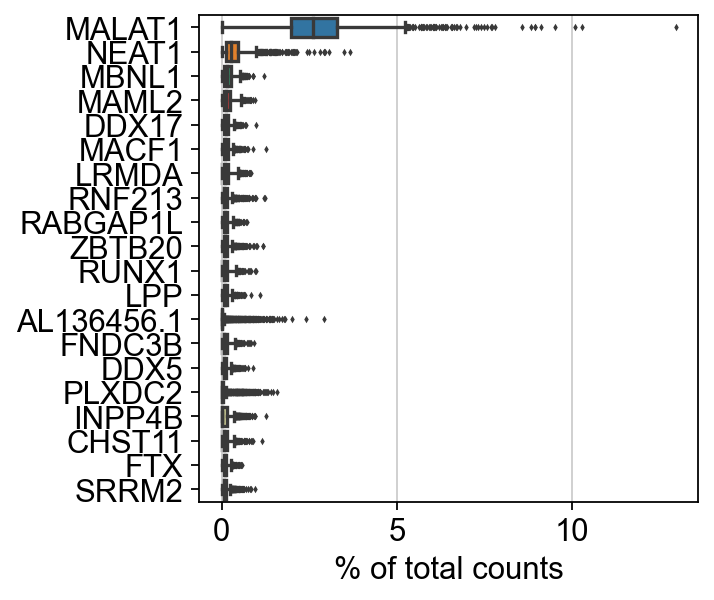

In [7]:
# 1. highest expressed genes
fig1, ax = plt.subplots()
p_box = sc.pl.highest_expr_genes(adata, n_top=20, show=False, ax=ax)


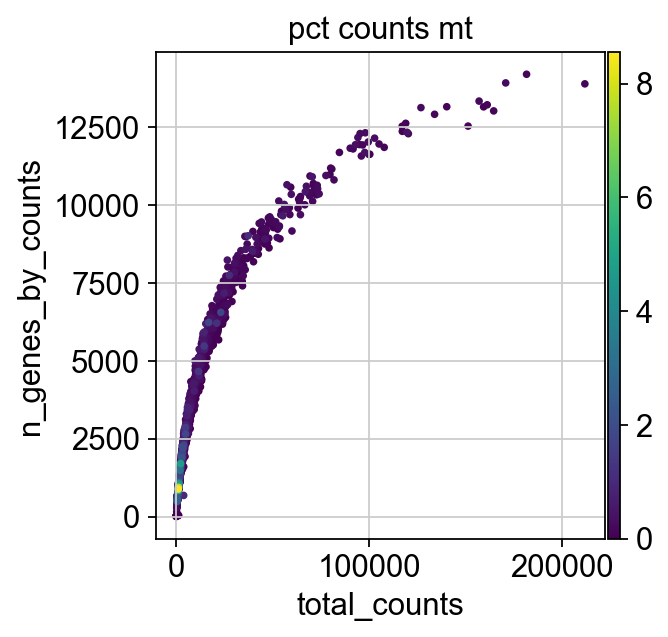

In [8]:
# 2. scatter QC metrics

# https://github.com/scverse/scanpy/issues/2135
p_scatter = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="pct_counts_mt",ax=None, show=False)

fig2 = plt.gcf()


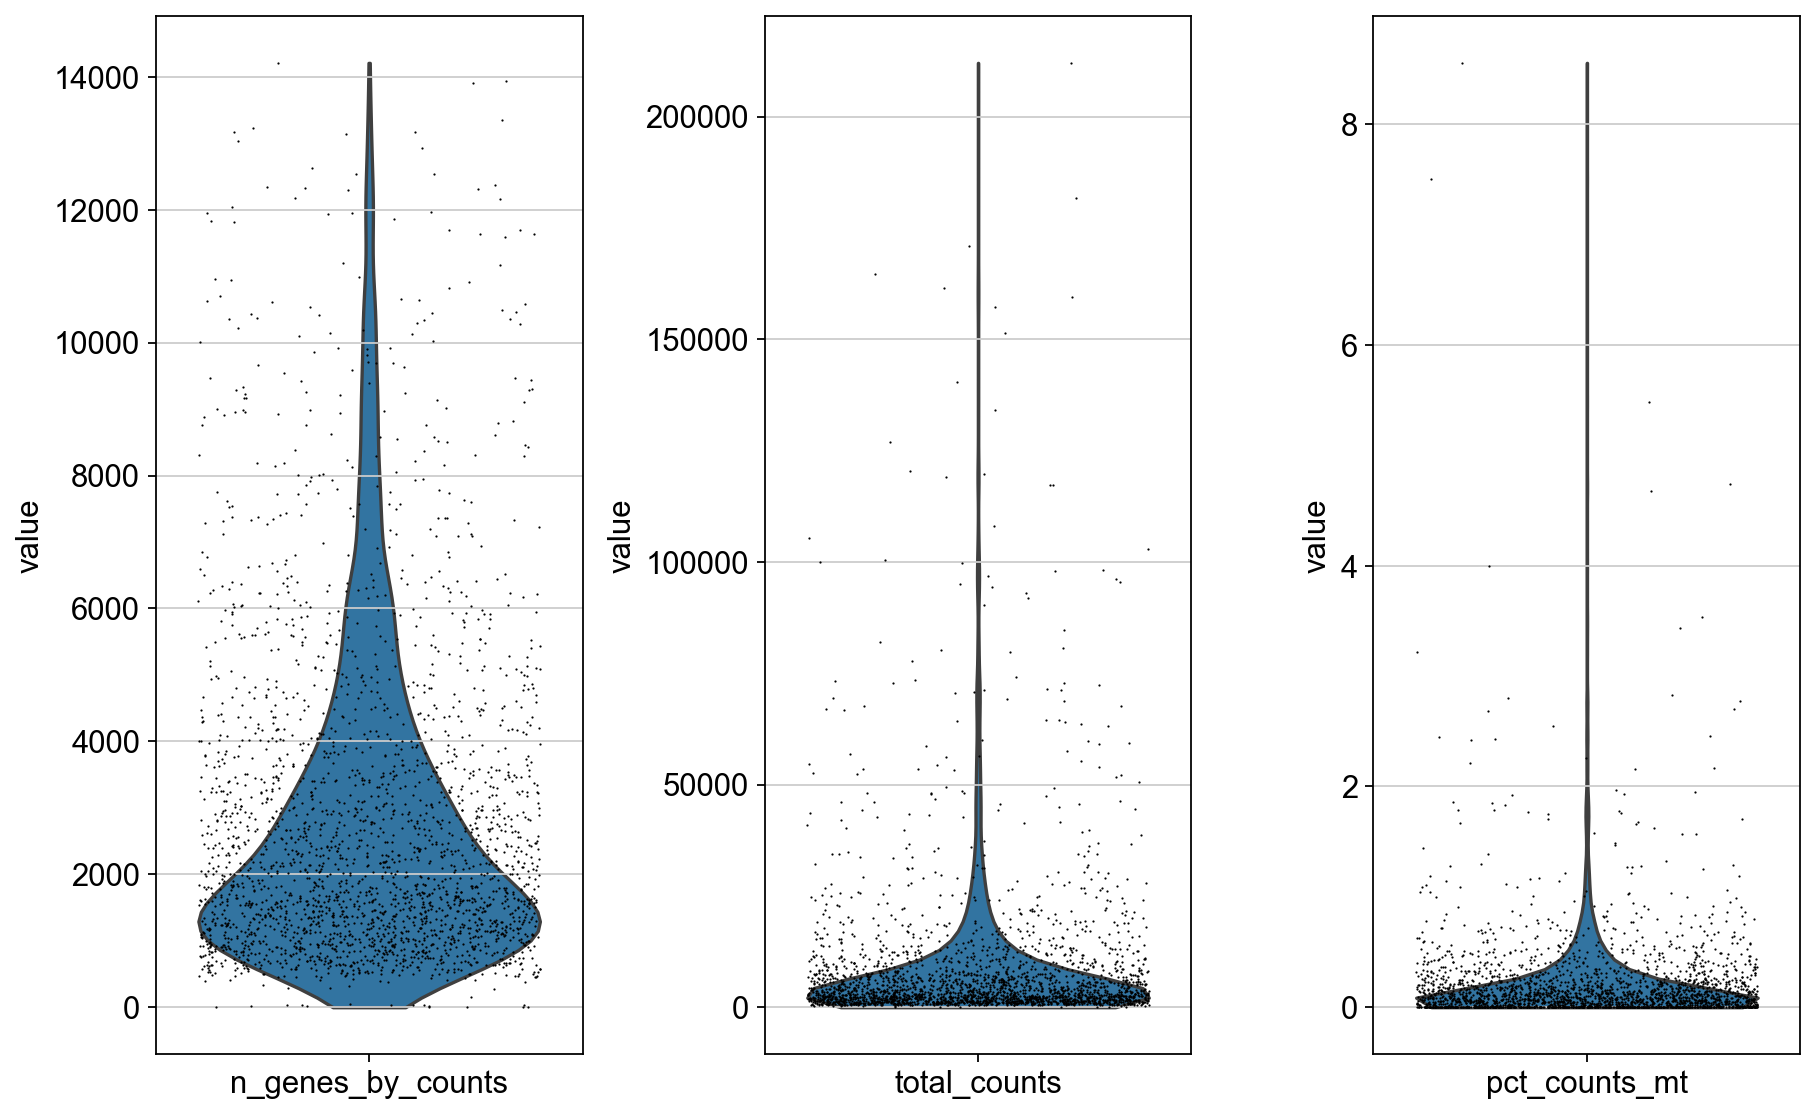

In [9]:
# 3. violin QC metrics
fig3, axes = plt.subplots(1,3, figsize = (12, 8))
fig3.tight_layout(pad=3)
p_violin = sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, show=False, ax=axes[0])
p_violin = sc.pl.violin(adata, ['total_counts'], jitter=0.4, show=False, ax=axes[1])
p_violin = sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, show=False, ax=axes[2])

## Filter

In [10]:
# data shape without filtering

adata.shape

# (X, Y) where X is the number of good-quality cells and Y is the number of good-quality genes

(2546, 36601)

In [16]:
# Because I wrote the following three functions into a script under /pipeline/QC_and_norm.py, I could import them like below

from pipeline.step1_qc_norm_cluster import calculate_qc_metrics, load_yubin_filters, hard_filter_sample

# For clarity, I will write the functions here again
def calculate_qc_metrics(adata):
    # 1. label MT, RB, HB genes
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

    # 2. compute the doublet scores
    scrub = scr.Scrublet(adata.X)
    doublet_scores, _ = scrub.scrub_doublets()
    adata.obs['scrublet_scores'] = doublet_scores
    
    #adata = adata[adata.obs['scrublet_scores'] <= 0.2]
    
    # 3. calculate the saturation counts
    sc.pp.calculate_qc_metrics(adata, percent_top=(5, 10, 20, 50, 100, 200, 500), inplace=True)
    adata.obs['n_counts_sat'] = [1000]*adata.shape[0]
    adata.obs['n_counts_sat'] = np.min(adata.obs[['total_counts', 'n_counts_sat']], axis=1)
    adata.obs['n_genes_sat'] = [1000]*adata.shape[0]
    adata.obs['n_genes_sat'] = np.min(adata.obs[['n_genes_by_counts', 'n_genes_sat']], axis=1)
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    
    return adata

# ===== from Yubin =====
def load_yubin_filters():
    yubin_filters = {
        'min_genes_per_cell': 127, 
        'min_counts_per_cell': 255, 
        'min_cells_per_gene': 10, 
        'max_counts_per_gene': None, 
        'remove_cells_with_high_mt': 5, 
        'remove_mt_genes': True,
        'remove_rb_genes': True,
    }

    return yubin_filters

def hard_filter_sample(adata, filters: dict):
    '''

    '''
    orig_data_shape = adata.shape

    if (min_counts_per_cell := filters.get('min_counts_per_cell')):
        sc.pp.filter_cells(adata, min_counts=min_counts_per_cell)
        # logger.info(f"Filtered {np.sum(adata.obs['total_counts'] > min_counts_per_cell)} / {adata.obs.shape[0]} cells with less than {min_genes_per_cell} genes expressed")

    if (min_genes_per_cell := filters.get('min_genes_per_cell')):
        sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
        # logger.info(f'Filtered {} / {} cells with less than {min_genes_per_cell} genes expressed')

    if (max_counts_per_gene := filters.get('max_counts_per_gene')):
        sc.pp.filter_genes(adata, max_counts=max_counts_per_gene)

    if (min_cells_per_gene := filters.get('min_cells_per_gene')):
        sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)
    
    if (remove_cells_with_high_mt := filters.get('remove_cells_with_high_mt')):
        if not 'pct_counts_mt' in adata.obs.columns:
            sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
        adata = adata[adata.obs['pct_counts_mt'] < remove_cells_with_high_mt, :]
    if (remove_mt_genes := filters.get('remove_mt_genes')):
        adata = adata[:, ~adata.var_names.str.startswith('mt-')]
    if (remove_rb_genes := filters.get('remove_rb_genes')):
        adata = adata[:, ~adata.var_names.str.startswith('RPS') | ~adata.var_names.str.startswith('RPL')]
    if (remove_hb_genes := filters.get('remove_hb_genes')):
        adata = adata[:, ~adata.var_names.str.contains(("^HB[^(P)]"))]

    filtered_data_shape = adata.shape
    print(f"Filtered {orig_data_shape[0] - filtered_data_shape[0]} cells and {orig_data_shape[1] - filtered_data_shape[1]} genes")

    return adata


In [14]:
calculate_qc_metrics(adata)
yubin_filters = load_yubin_filters()

Preprocessing...


/Users/haochen/anaconda3/envs/scanpy/lib/python3.10/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in divide
  w.setdiag(float(target_total) / tots_use)


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 27.8%
Elapsed time: 4.5 seconds


/var/folders/l9/hht5tb6n65b1471sycxbs7w00000gn/T/ipykernel_9085/1506882676.py:29: RuntimeWarning: invalid value encountered in divide
  adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1


In [17]:
adata_filtered = hard_filter_sample(adata, yubin_filters)
adata_filtered.shape

Filtered 3 cells and 0 genes


(2528, 20681)

## Normalization (log1p)

In [18]:
# PF-log1p-PF method from best practices handbook

from pipeline.step1_qc_norm_cluster import log1p_normalize_data

log1p_normalize_data(adata_filtered)

/Users/haochen/Desktop/prePOLAR/snRNAseq/tools/scanpy/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
# Karthik method

def karthik_normalize_data(adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    return adata

In [20]:
karthik_normalize_data(adata_filtered)

AnnData object with n_obs × n_vars = 2528 × 20681
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'scrublet_scores', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts_sat', 'n_genes_sat', 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'hb', 'n_cells'
    uns: 'log1p'
    layers: 'log1pPF_normalization', 'PFlog1pPF_normalization', 'counts'

In [21]:
adata_filtered.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_in_top_50_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,scrublet_scores,pct_counts_in_top_5_genes,pct_counts_in_top_10_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_counts_sat,n_genes_sat,percent_mito,n_counts,n_genes
TGTGGTAAGAAACCGC-1,13902,9.539860,212047.0,12.264568,6.976755,10.675463,213.0,5.365976,0.100449,0.103586,4.119841,5.265814,15.128250,21.522115,34.301358,1000.0,1000,0.001004,211885.0,13752
GCTTCCACAGCTGCTG-1,14210,9.561772,181805.0,12.110696,7.113116,10.442507,242.0,5.493062,0.133110,0.174785,4.588983,5.553753,14.572757,20.672699,32.873133,1000.0,1000,0.001331,181608.0,14023
ATCGAGTGTCACCTAA-1,13932,9.542015,170981.0,12.049314,7.525398,10.936303,435.0,6.077642,0.254414,0.136691,5.062551,6.011194,15.228008,21.411151,33.624789,1000.0,1000,0.002544,170774.0,13731
TACGGGCAGGGCATGT-1,13033,9.475317,164742.0,12.012142,7.456508,11.008729,192.0,5.262690,0.116546,0.121951,4.763813,5.804834,15.338529,21.789222,34.439912,1000.0,1000,0.001165,164591.0,12896
GAAACTCTCAGTGCAT-1,13229,9.490242,161394.0,11.991611,8.187417,12.011599,163.0,5.099866,0.100995,0.154047,5.258560,6.482273,16.581781,22.979789,35.648785,1000.0,1000,0.001010,161200.0,13049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGTTAGAGACGCACA-1,381,5.945421,437.0,6.082219,13.501144,24.256293,1.0,0.693147,0.228833,0.036088,6.178490,8.924485,35.697941,58.581236,100.000000,437.0,381,0.002288,437.0,381
TTCGAAGAGTTTGCGT-1,379,5.940171,453.0,6.118097,14.128035,27.373068,0.0,0.000000,0.000000,0.013263,5.960265,9.271523,38.410596,60.485651,100.000000,453.0,379,0.000000,453.0,379
AGCAGCCGTGCTAGCC-1,326,5.789960,360.0,5.888878,14.444444,23.333333,0.0,0.000000,0.000000,0.023116,6.111111,8.888889,37.222222,65.000000,100.000000,360.0,326,0.000000,359.0,325
GGCAATTAGAAACCTA-1,282,5.645447,317.0,5.762052,16.088328,26.813880,0.0,0.000000,0.000000,0.029126,6.309148,9.779180,42.586751,74.132492,100.000000,317.0,282,0.000000,317.0,282


## PCA clustering

In [22]:
def plot_hvg(adata, sample_name = '', write_figure=True):
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=1000)
    if write_figure:
        out_f = f'{sample_name}-HVG_plot.png'
        sc.pl.highly_variable_genes(adata, show=False, save=out_f)

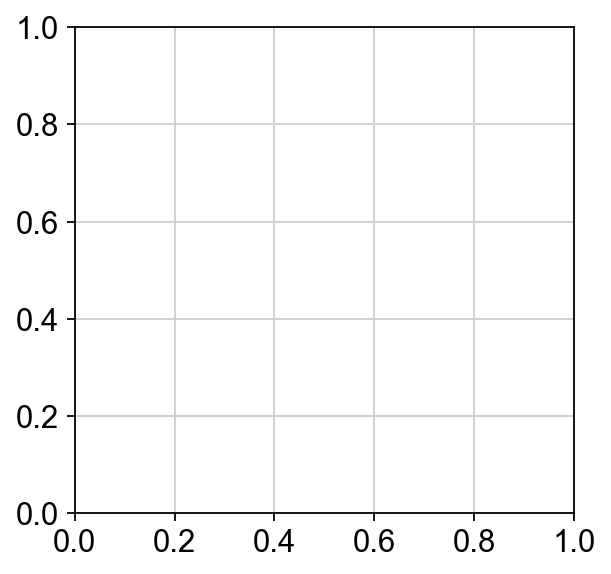

In [23]:
# As you can read in the above function, by default it will write the figure to the figure directory defined at the top of this notebook:
# ---> sc.settings.figdir = '/Users/haochen/Desktop/prePOLAR/snRNAseq/hz-analysis/outputs/Step1-individual-QC_norm_cluster/PP01'

plot_hvg(adata_filtered, sample_name = 'PP01',)

In [26]:
# this function will perform:
# -- PCA
# -- Neighbors
# -- Leiden clustering
# -- UMAP

# again, by defalt it will save the PCA figures to the figure directory defined at the top of this notebook

def cluster_data(adata, sample_name = '', write_figure=True):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata)
    sc.tl.umap(adata)
    
    if write_figure:
        out_f_prefix = f'{sample_name}-'
        sc.pl.pca(adata, color='CST3', show=False, save=f'{out_f_prefix}pca.pdf') # gene marker is hard coded to `CST3` which is a marker of Schwann cells and Langherans cells
        sc.pl.pca_variance_ratio(adata, log=True, show=False, save=f'{out_f_prefix}pcavariance.png')

In [27]:
cluster_data(adata_filtered, sample_name = 'PP01')

In [28]:
# as you can see, the PCA/UMAP layers have been added to the adata object

adata_filtered

AnnData object with n_obs × n_vars = 2528 × 20681
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'scrublet_scores', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts_sat', 'n_genes_sat', 'percent_mito', 'n_counts', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1pPF_normalization', 'PFlog1pPF_normalization', 'counts'
    obsp: 'distances', 'connectivities'

## Annotate cells

In [30]:
# we could import the reference functions from the pipeline script
# but for clarity I copy them below again
from pipeline.fetch_references import load_karthik_genemarkers, get_broad_celltypes

def load_karthik_genemarkers(filename="/Users/haochen/Desktop/prePOLAR/snRNAseq/hz-analysis/reference/karthik-gene_markers.use.txt"):
    genemarkers = {}

    f = open(filename)
    for line in f:
        tokens = line.strip().split('\t')
        if len(tokens) > 1:
            markers = [gene.upper() for gene in tokens[1:]]
            genemarkers[tokens[0]] = markers
    return genemarkers

def get_broad_celltypes():
    broad_celltypes = {
        "MALIGNANT CELLS" : ['Moffitt_basal','Moffitt_classical','Bailey_squamous','Bailey_progenitor','Collison_QM','Collison_classical'],
        "ACINAR": ["ACINAR"],
        "ENDOCRINE": ["Alpha","Beta","Delta","Gamma","Episilon"],
        "ENDOTHELIAL": ["ENDOTHELIAL"],
        "IMMUNE": ['Pan_Immune','AntigenPresentingCells','Monocytes_1','Monocytes_2','Macrophage','cDC1','cDC2','DC_activated','pDC','Mast','Eosinophils','Neutrophils','M0','M1','M2','Mast_Resting','Mast_activated','CD8_Tcells','CD4_Tcells','NK','CD8_gammadelta','CD8_exhausted','CD4_naive','CD4_memory_resting','CD4_memory_activated','CD4_follicular_helper','CD4_regulatory','NK_resting','NK_activated','B_cell','Plasma','Bcell_naive','Bcell_memory'],
        "FIBROBLASTS": ['PanCAF','iCAF','myCAF','apCAF','CAF','Tuveson_iCAF','Tuveson_mCAF','Neuzillet_CAFa','Neuzillet_CAFb','Neuzillet_CAFc','Neuzillet_CAFd','Davidson_CAF1','Davidson_CAF2','Davidson_CAF3','Pan_Stellate','Quiescent_Stellate','Activated_Stellate','Immune_Stellate'],
        "PANCREATIC_SCHWANN_CELLS": ['PANCREATIC_SCHWANN_CELLS'],
        "DUCTAL":['ductal14', 'ductal2','ductal3','ductal4']
    }
    return broad_celltypes

In [31]:
karthik_genemarkers = load_karthik_genemarkers() 
broad_celltypes = get_broad_celltypes()

In [32]:
# score cells based on gene signatures
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # suppress FutureWarning

# the main function used is the `sc.tl.score_genes` function
for broad_celltype, specific_celltypes in broad_celltypes.items():
    allmarkers = set()
    for celltype in specific_celltypes:
        markers = karthik_genemarkers[celltype]
        allmarkers = allmarkers.union(set(markers))
        sc.tl.score_genes(adata_filtered, markers, score_name=celltype, use_raw=True)
    sc.tl.score_genes(adata_filtered, allmarkers, score_name=broad_celltype, use_raw=True)

## UMAP's

In [33]:
from scanpy.plotting.palettes import *

/Users/haochen/Desktop/prePOLAR/snRNAseq/tools/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


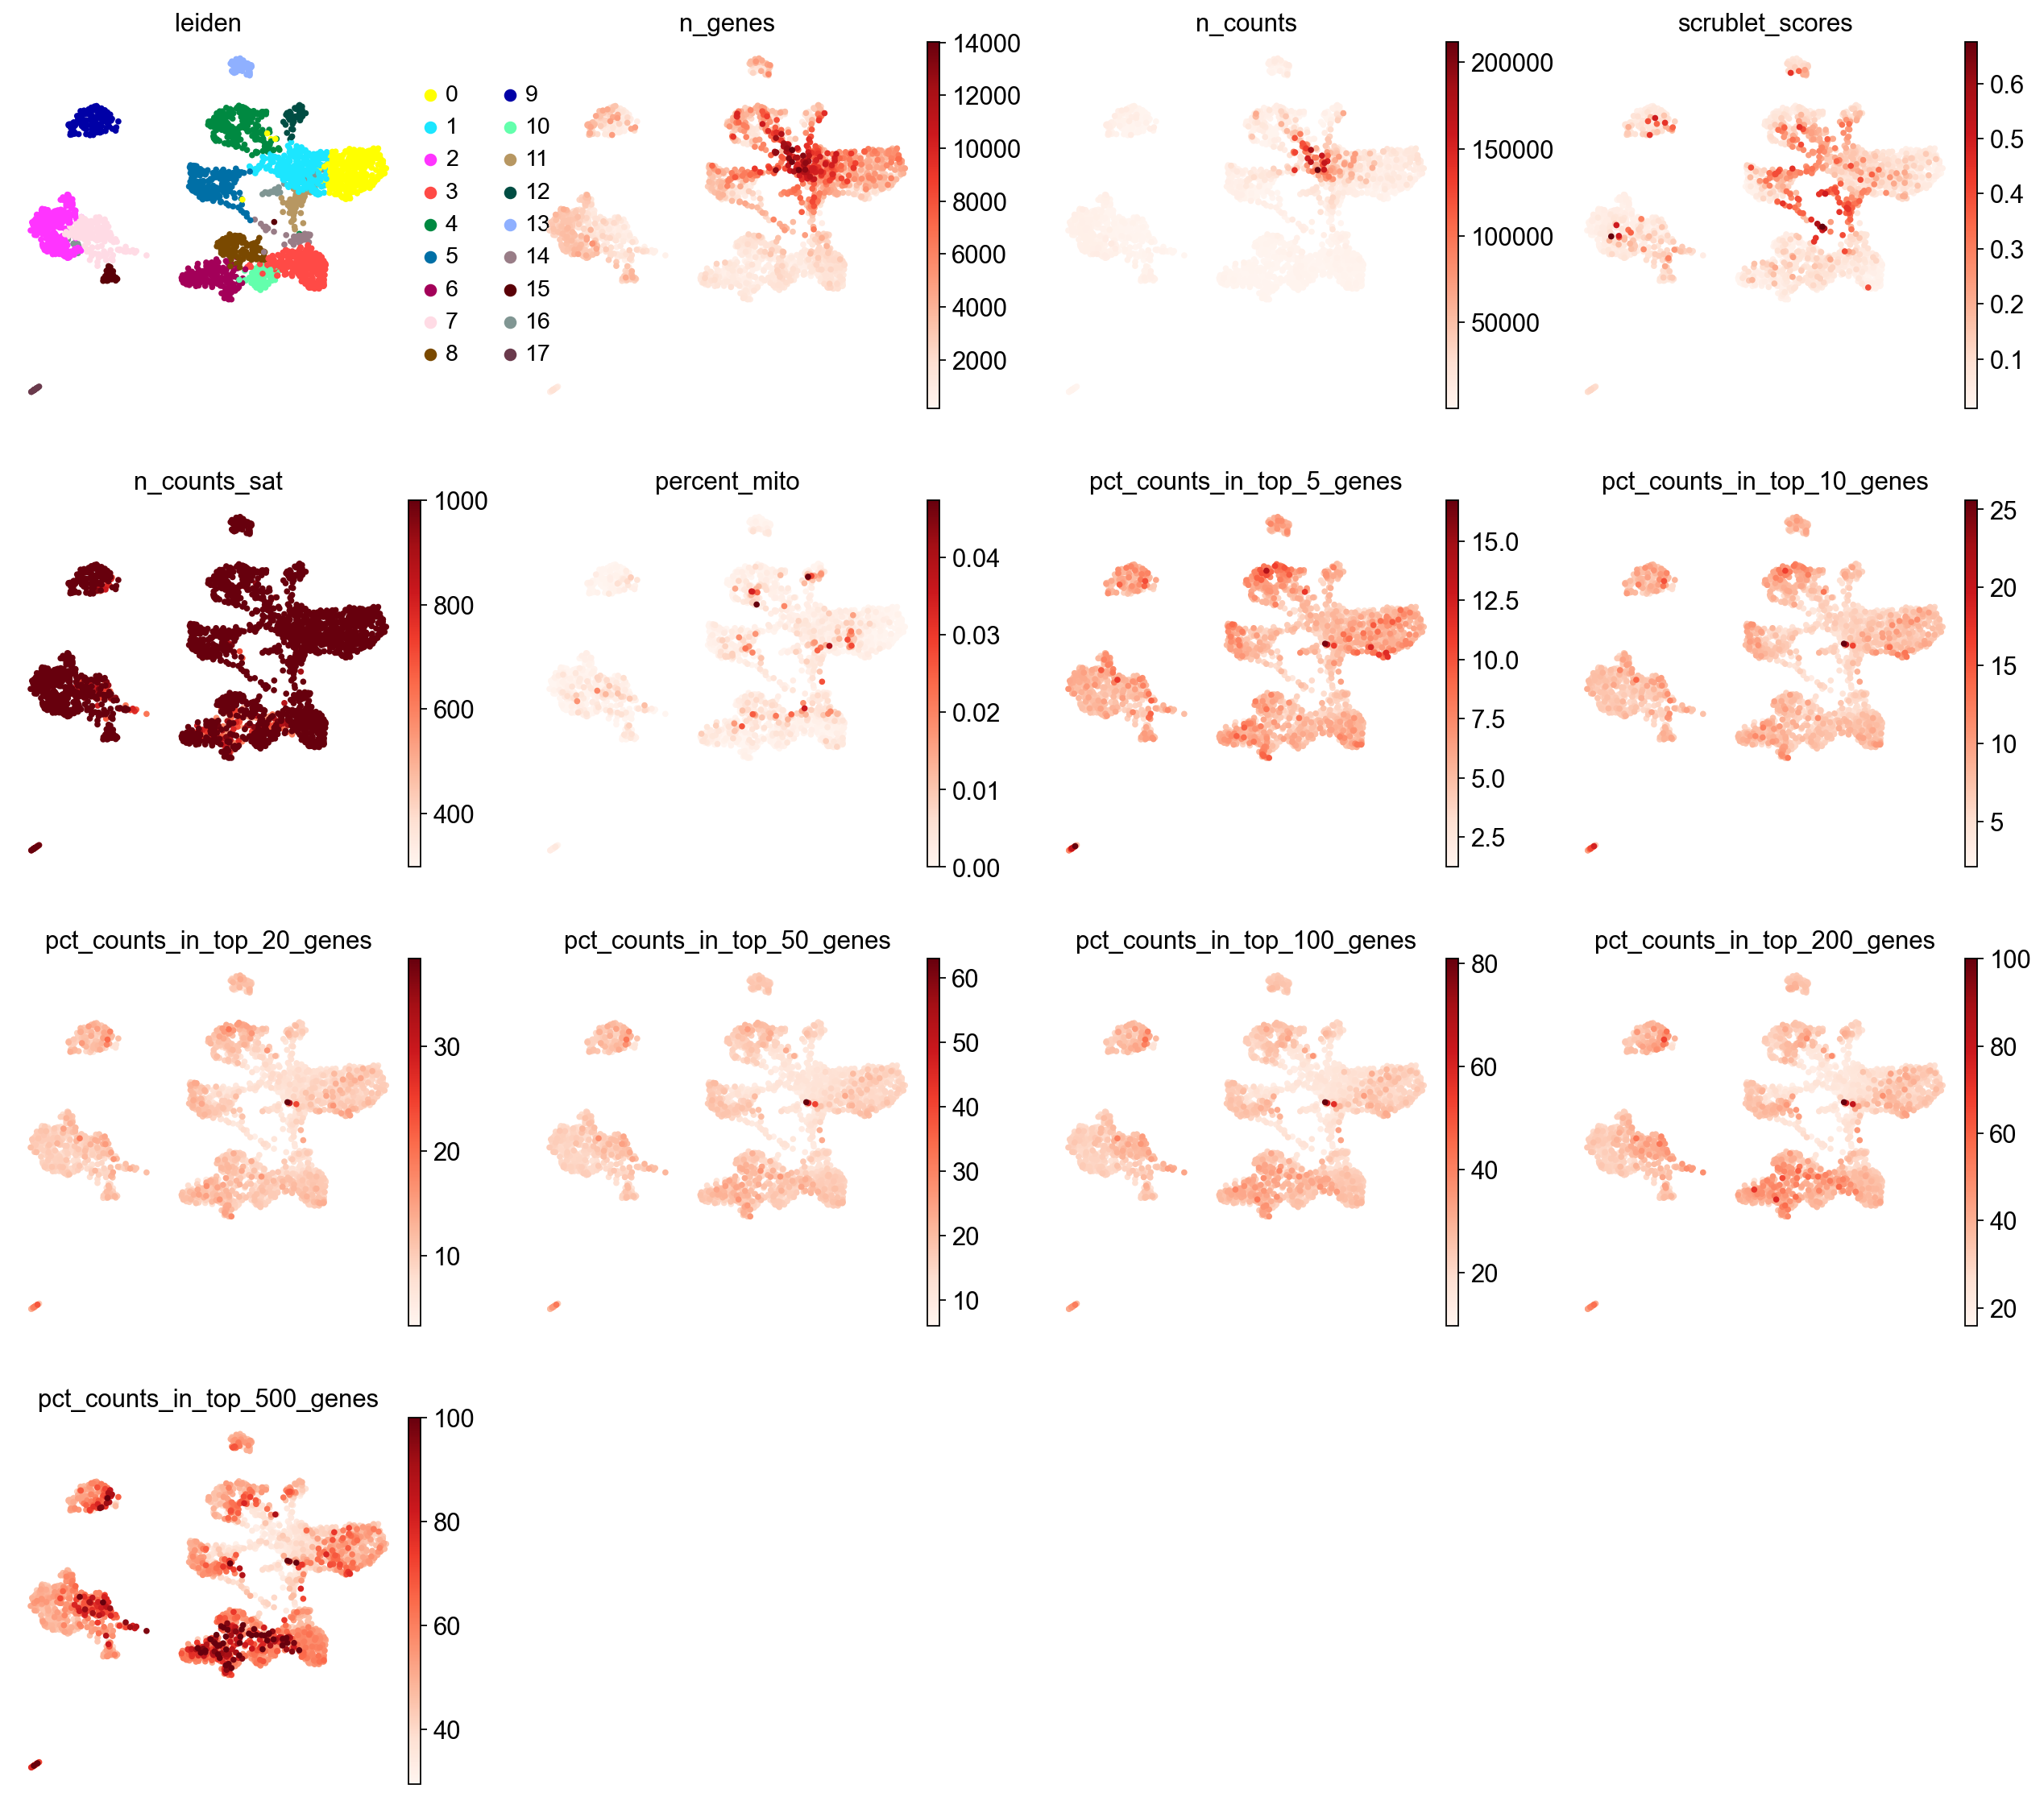

Broad Cell types


/Users/haochen/Desktop/prePOLAR/snRNAseq/tools/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


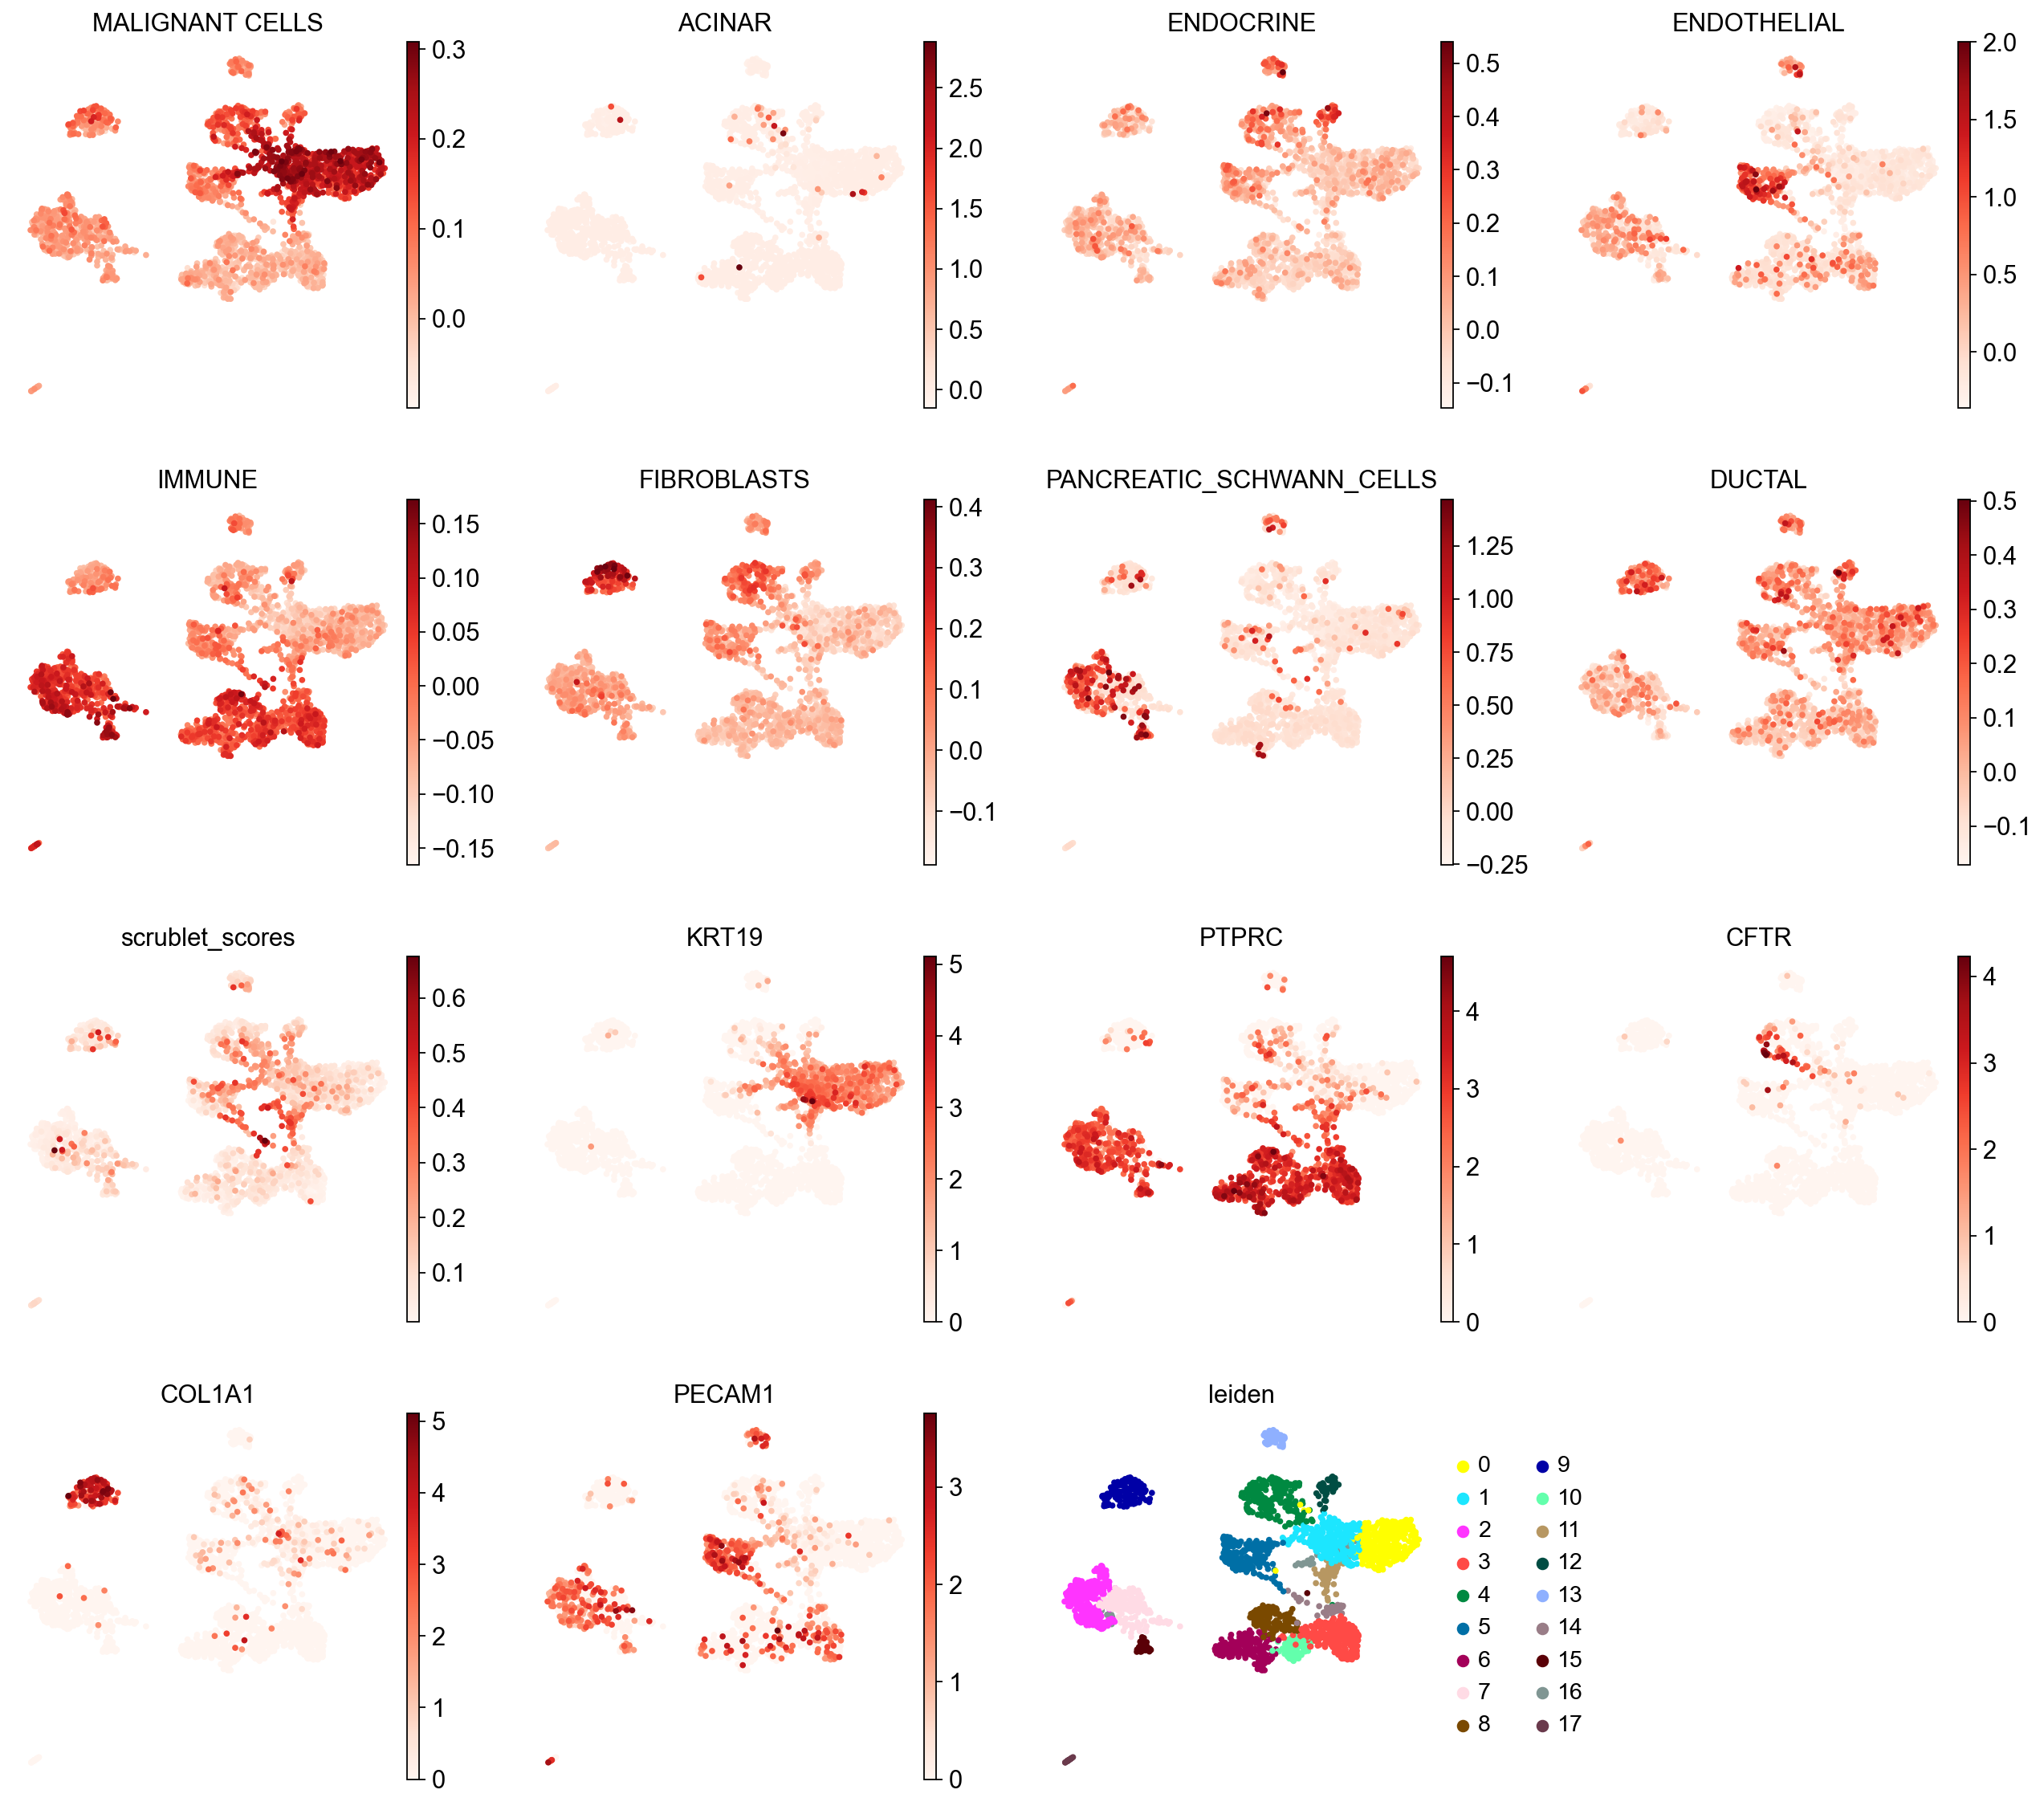

MALIGNANT CELLS
ENDOCRINE
IMMUNE
FIBROBLASTS
DUCTAL


In [34]:
my_palette = godsnot_102
sample_name = 'PP01'


# plot umaps
sc.pl.umap(adata_filtered, color=['leiden', 'n_genes', 'n_counts', 'scrublet_scores', 'n_counts_sat', 'percent_mito', 'pct_counts_in_top_5_genes',
                        'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes',
                        'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'], palette=my_palette, color_map='Reds')
print ("Broad Cell types")
sc.pl.umap(adata_filtered, color=list(broad_celltypes.keys())+['scrublet_scores', 'KRT19', 'PTPRC', 'CFTR', 'COL1A1', 'PECAM1', 'leiden'], color_map='Reds', palette=my_palette)

for broad_celltype, specific_celltypes in broad_celltypes.items():
    if len(specific_celltypes) > 1:
        print (broad_celltype)
        sc.pl.umap(adata_filtered, color=specific_celltypes, palette=my_palette, show=False, save=sample_name+'.'+broad_celltype+'.png')